# Fashion-MNIST Notebook
In this notebook we will try to classify different fashion items and clothes based on black-and-white pictures from the "fashion mnist" dataset without using neural networks.


Importing libraries and data:

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist #dataset

In [2]:
(f_X_train, f_y_train), (X_test, y_test) = fashion_mnist.load_data() #dataset split
f_X_train.shape

(60000, 28, 28)

## Data Preparations

The dataset is an educational dataset, therefore the data is clean and useable (only simple scaling is required)

Example picture from the dataset:

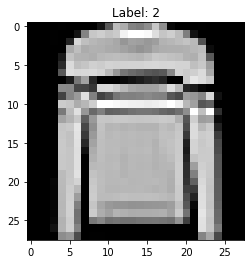

In [3]:
import matplotlib.pyplot as plt
example_img=f_X_train[5]
plt.imshow(example_img, cmap="gray")
plt.title('Label: '+str(f_y_train[5]))
plt.show()

## Labels legend:
0- T-shirt/top  
1- Trouser  
2- Pullover  
3- Dress  
4- Coat  
5- Sandal  
6- Shirt  
7- Sneaker  
8- Bag  
9- Ankle boot

In [4]:
labels=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

The picture in the example (picture no. 5) represents a Pullover.

In [5]:
# test dataset size 
y_test.size

10000

Each picture has 28*28 pixels, 784 dimensions to the data.  
It's very hard to handle and not very effective because there are some pixels who are similar for all pictures (for example the pixels at the corners).

We will combat this problem in two ways, the first will be a limited decision tree.  
The tree will choose the most relevant dimensions to divide the data by.

The second solution will be dimensional reduction using PCA, with this method we will not only choose the most useful dimensions but also create new dimenstions that will represent combinations of multiple dimensions, compressing the data to less dimensions.

In [6]:
#making sure data is not distorted
print ('max pixel value: ' + str(f_X_train.max()))
print ('min pixel value: '+ str(f_X_train.min()))
print ('mean pixel value: '+ str(f_X_train.mean()))

max pixel value: 255
min pixel value: 0
mean pixel value: 72.94035223214286


In [7]:
#scaling
f_X_train_sc=f_X_train/255
print('after scaling:')
print ('max pixel value: ' + str(f_X_train_sc.max()))
print ('min pixel value: '+ str(f_X_train_sc.min()))
print ('mean pixel value: '+ str(f_X_train_sc.mean()))

after scaling:
max pixel value: 1.0
min pixel value: 0.0
mean pixel value: 0.2860405969887955


Text(0.5, 1.0, 'frequency of labels')

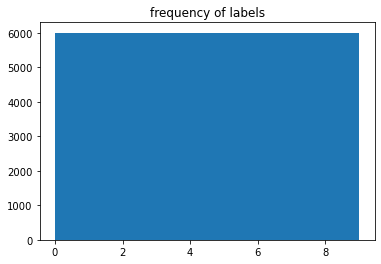

In [8]:
#samples distribution
plt.hist(f_y_train)
plt.title('frequency of labels')

Equal representation for all labels.
The dataset is balanced, so good scores will translate well to the test set and real-life scenarios.

Reshaping the dataset to fit the classifiers:

In [9]:
f_X_train_sc=f_X_train_sc.reshape((60000,784))
f_X_train_sc.shape

(60000, 784)

Scaling and reshaping the test set:

In [10]:
X_test_sc=X_test/255
X_test_sc=X_test_sc.reshape((10000,784))
print('test set shape: '+str(X_test_sc.shape))
print('test set max:'+ str(X_test_sc.max()))

test set shape: (10000, 784)
test set max:1.0


The test set will serve as final evaluation for the final algorithm.  
We will perform the algorithms tuning on the evaluation set:

In [11]:
from sklearn.model_selection import train_test_split
X_train_sc, X_eval, y_train, y_eval = train_test_split(f_X_train_sc, f_y_train, test_size=0.2, random_state=42)

In [12]:
X_train_sc.shape

(48000, 784)

In [13]:
X_eval.shape

(12000, 784)

## Decision Tree
Decision tree learning or induction of decision trees is one of the predictive modelling approaches used in statistics, data mining and machine learning. It uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves). Tree models where the target variable can take a discrete set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. (wikipedia)

Scoring method: in multiclass classifications there are several scoring methods.  
The method I will use is accuracy, we will try to classify as many cases as possible.  
The data is balanced, so good accuracy = good performance.

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dtc=DecisionTreeClassifier(random_state=0, max_depth=10)
dtc.fit(X_train_sc, y_train)
dtc_pred1 = dtc.predict(X_train_sc)
print ('train set accuracy: '+str(accuracy_score(y_train,dtc_pred1)))

train set accuracy: 0.8511041666666667


The results look fine, we will try to improve the performance with grid search on the tree hight.

In [15]:
from sklearn.model_selection import GridSearchCV
depths={'max_depth':[5,10,15,20]}
grid=GridSearchCV(dtc,depths,scoring='accuracy',cv=5)
grid.fit(X_train_sc,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=10, random_state=0),
             param_grid={'max_depth': [5, 10, 15, 20]}, scoring='accuracy')

In [16]:
#plotting the results
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.347612,0.096854,0.023221,0.001840,5,{'max_depth': 5},0.711458,0.707187,0.704479,0.703438,0.707292,0.706771,0.002785,4
1,11.180348,0.385905,0.026589,0.001629,10,{'max_depth': 10},0.813125,0.802396,0.805417,0.801562,0.806667,0.805833,0.004101,2
2,16.542660,0.373922,0.028001,0.000650,15,{'max_depth': 15},0.808438,0.798438,0.808958,0.806042,0.811979,0.806771,0.004575,1
3,18.638318,0.156237,0.028230,0.000413,20,{'max_depth': 20},0.801979,0.794167,0.801250,0.791667,0.801354,0.798083,0.004299,3


<AxesSubplot:xlabel='param_max_depth', ylabel='mean test score'>

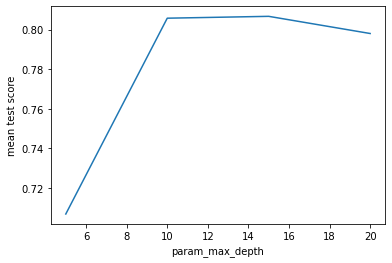

In [17]:
d_compare=pd.DataFrame(grid.cv_results_)[['mean_test_score','param_max_depth']]
d_compare.plot(y='mean_test_score',x='param_max_depth',legend=False,ylabel='mean test score')

the graph peaks at max_depth=15, so we will use this parameter in the final evaluation on the test set.

In [18]:
dtc=grid.best_estimator_
dtc_pred=dtc.predict(X_eval)
dtc_pred

array([8, 8, 7, ..., 8, 8, 6], dtype=uint8)

### Decision tree results

In [19]:
#test score
print('decision tree test accuracy: '+str(accuracy_score(y_eval,dtc_pred)))

decision tree test accuracy: 0.8131666666666667


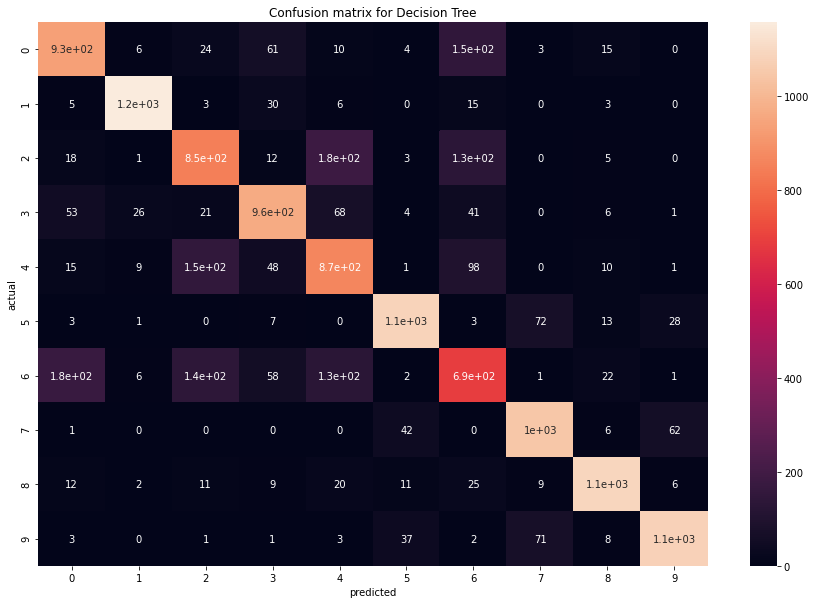

In [20]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(15,10))
sns.heatmap(confusion_matrix(y_eval,dtc_pred),annot=True)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Confusion matrix for Decision Tree')
plt.show()

The best classified label is 1 (Trouser), The most confused labels are 2 and 4 (Pullover and Coat) which is understandable.  
Another common mistakes: 0 and 6 (T-shirt/top and Shirt)  
                         2 and 6 (Pullover and Shirt)  
                         4 and 6 (Coat and Shirt)  
The classifier had the most mistakes with label 6 (Shirt).

## Random Forest
Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. For regression tasks, the mean or average prediction of the individual trees is returned. Random decision forests correct for decision trees' habit of overfitting to their training set. Random forests generally outperform decision trees. (wikipedia)

We will try to improve the previus attempt by implementing this ensemble-learning algorithem that is based on decision trees.  
We will limit the trees to maximum depth of 15 and play with the number of trees.  


In [21]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(max_depth=15, random_state=0)
rfc.fit(X_train_sc,y_train)

RandomForestClassifier(max_depth=15, random_state=0)

The default number of trees is 100.

In [22]:
rfc.score(X_train_sc,y_train)

0.9679583333333334

Initial score looks good, now we will try to improve it.

In [23]:
grid=GridSearchCV(rfc,{'n_estimators':[60,80,100,120,140]},cv=3,scoring='accuracy')
grid.fit(X_train_sc,y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_depth=15, random_state=0),
             param_grid={'n_estimators': [60, 80, 100, 120, 140]},
             scoring='accuracy')

<AxesSubplot:xlabel='param_n_estimators', ylabel='mean test score'>

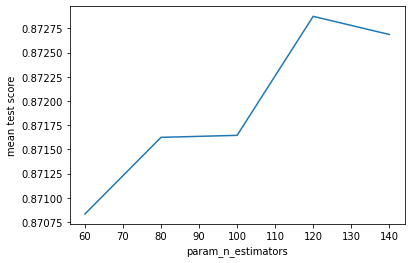

In [24]:
n_compare=pd.DataFrame(grid.cv_results_)[['mean_test_score','param_n_estimators']]
n_compare.plot(y='mean_test_score',x='param_n_estimators',legend=False,ylabel='mean test score')

In [25]:
grid=GridSearchCV(rfc,{'n_estimators':[120,140,160,180]},cv=3,scoring='accuracy')
grid.fit(X_train_sc,y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_depth=15, random_state=0),
             param_grid={'n_estimators': [120, 140, 160, 180]},
             scoring='accuracy')

<AxesSubplot:xlabel='param_n_estimators', ylabel='mean test score'>

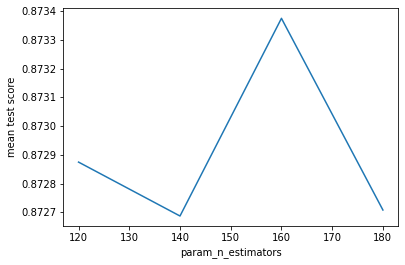

In [26]:
n_compare=pd.DataFrame(grid.cv_results_)[['mean_test_score','param_n_estimators']]
n_compare.plot(y='mean_test_score',x='param_n_estimators',legend=False,ylabel='mean test score')

Further improvement is not worth the computing power, we will leave the estimator at 160 trees.

### Random forest results

In [27]:
#test score
rfc=grid.best_estimator_
rfc_pred=rfc.predict(X_eval)
print ('Random forest accuracy: '+str(accuracy_score(y_eval,rfc_pred)))

Random forest accuracy: 0.8765833333333334


The accuracy is much better than 0.8131 from the Decision tree.

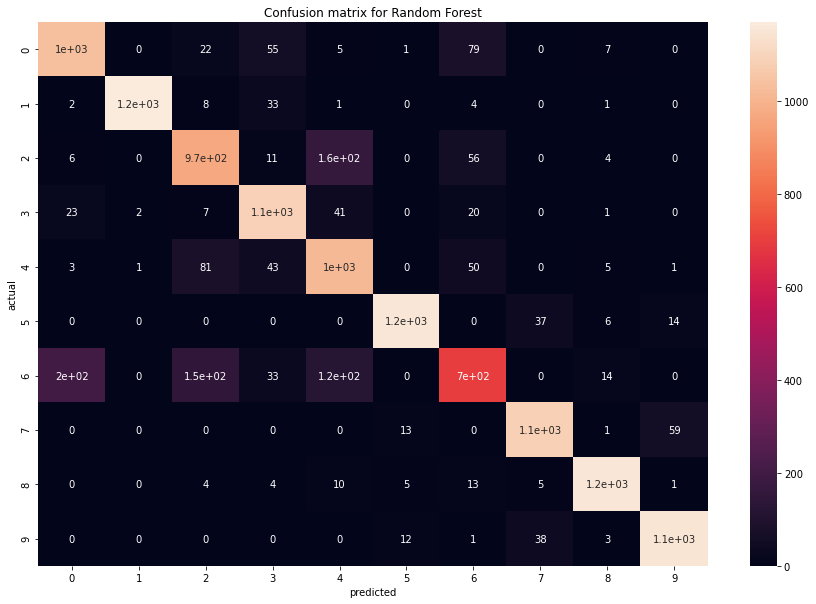

In [28]:
#confusion matrix
plt.figure(figsize=(15,10))
sns.heatmap(confusion_matrix(y_eval,rfc_pred),annot=True)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Confusion matrix for Random Forest')
plt.show()

Many mistakes were corrected, but number of 6 (Shirt) classified as 0 (T-shirt/top) increased.

## PCA

Before moving to another ensemble-learning algorithm we will reduce the dimensions of the problem.  
To do so we will use the PCA (Principal Component Analysis) method.  
Using this method we can decide how much of the variance in the data we want to keep and the algorithm will choose/create the parameters that will satisfy our need with minimal dimensions count.  
For further read visit: https://en.wikipedia.org/wiki/Principal_component_analysis

In [29]:
from sklearn.decomposition import PCA
pca=PCA(n_components=0.9,svd_solver='auto',random_state=42)
X_reduce=pca.fit_transform(X_train_sc)
X_reduce.shape

(48000, 84)

applying same reduction to the test set:

In [30]:
X_eval_red=pca.transform(X_eval)
X_eval_red.shape

(12000, 84)

We reduced the number of dimentions to 84 (from 784) whie keeping 90% of the variance.
Let's compare decision tree on the full data versus on the reduced data.

In [31]:
dtc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 0,
 'splitter': 'best'}

In [32]:
#on regular dataset
dtc.fit(X_train_sc,y_train)

DecisionTreeClassifier(max_depth=15, random_state=0)

In [33]:
print('accuracy without PCA: '+str(dtc.score(X_eval,y_eval)))

accuracy without PCA: 0.8131666666666667


In [34]:
#on reduced dataset
dtc.fit(X_reduce,y_train)

DecisionTreeClassifier(max_depth=15, random_state=0)

In [35]:
print('accuracy with PCA: '+str(dtc.score(X_eval_red,y_eval)))

accuracy with PCA: 0.77225


### Measuring execution times for both classifiers:

In [36]:
%%time
dtc.fit(X_train_sc,y_train)

Wall time: 18.2 s


DecisionTreeClassifier(max_depth=15, random_state=0)

In [37]:
%%time
dtc.fit(X_reduce,y_train)

Wall time: 5.93 s


DecisionTreeClassifier(max_depth=15, random_state=0)

The reduced data took only 1/3 of the time for only 0.04 reduced accuracy.
In more complex models this will be the difference between usable and unusable.

## Gradient Boosting
Gradient boosting is a machine learning technique for regression, classification and other tasks, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. When a decision tree is the weak learner, the resulting algorithm is called gradient boosted trees, which usually outperforms random forest. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.  
For further read: https://en.wikipedia.org/wiki/Gradient_boosting  

The classifier we will use is tree based XGBoost, which combines weak decision-tree learners (slightly above 50% accuracy).

In [38]:
import xgboost as xgb
xgbc=xgb.XGBClassifier(n_estimators=50,use_label_encoder=False, eval_metric='mlogloss',random_state=1)

In [39]:
xgbc.fit(X_train_sc,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [40]:
xgbc.score(X_train_sc,y_train)

0.9870625

The score on the train set is impressive, but the classifier took very long time to create a model (even thogh we decreased n_estimators to 50).  
We will try to create a classifier on the reduced dataset, where we will be able to play with the classifier parameters and then compare between the two.

In [41]:
xgbc2=xgb.XGBClassifier(n_estimators=50,use_label_encoder=False, eval_metric='mlogloss',random_state=1)
xgbc2.fit(X_reduce,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [42]:
xgbc2.score(X_reduce,y_train)

0.9804375

The score is still impresive, but execution time is mach faster.

In [43]:
#trying different n_estimators, we used cv=2 to svae on running time
grid=GridSearchCV(xgbc2,{'n_estimators':[60,80,100,120]},cv=2,scoring='accuracy')
grid.fit(X_reduce,y_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eval_metric='mlogloss',
                                     gamma=0, gpu_id=-1, importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()', n_estimators=50,
                                     n_jobs=8, num_parallel_tree=1,
                                     objective='multi:softprob', random_state=1,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=1,
                                    

<AxesSubplot:xlabel='param_n_estimators', ylabel='mean test score'>

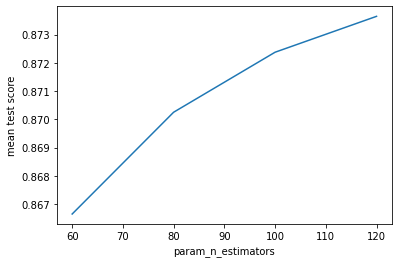

In [44]:
n_compare=pd.DataFrame(grid.cv_results_)[['mean_test_score','param_n_estimators']]
n_compare.plot(y='mean_test_score',x='param_n_estimators',legend=False,ylabel='mean test score')

The accuracy decreased drastically compared to the initial test, probably because we used cv=2 which split the data to half.  
The classifiers receives far less data and the measuring is done on a large set.  
Considering that, this results are very impressive.  
We will settle on n_estimators=120 for now.

In [45]:
xgbc2=grid.best_estimator_

The eval_metric='mlogloss' means the classifier "punishes" heafily for confident errors, we will try using eval_metric='merror' as well.

In [46]:
xgbc3=xgb.XGBClassifier(n_estimators=50,use_label_encoder=False,eval_metric='merror', random_state=0)
xgbc3.fit(X_reduce,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [47]:
#basic test
xgbc3.score(X_reduce,y_train)

0.9804375

seems pretty good.

### XGBoost results

In [48]:
#comparing XGBoost classifiers
print('mlogloss on full dataset accuracy: '+str(xgbc.score(X_eval,y_eval)))
print('mlogloss on reduced dataset accuracy: '+str(xgbc2.score(X_eval_red,y_eval)))
print('merror on reduced dataset accuracy: '+str(xgbc3.score(X_eval_red,y_eval)))

mlogloss on full dataset accuracy: 0.8941666666666667
mlogloss on reduced dataset accuracy: 0.8825833333333334
merror on reduced dataset accuracy: 0.8718333333333333


The results are better than the Random Forest (0.8765).  
The full classifier performed the best, but took the longest to create.

## Voting  
We will combine multiple classifiers we have using different voting methods.  
Hopefully resulting in a better classifier because different biases in the classifiers will balance each other.

In [49]:
from sklearn.ensemble import VotingClassifier
dtc_v=DecisionTreeClassifier(random_state=0, max_depth=15)
rfc_v=RandomForestClassifier(max_depth=15, random_state=0, n_estimators=100)
xgbc_v=xgb.XGBClassifier(n_estimators=50,use_label_encoder=False,eval_metric='mlogloss')

vc=VotingClassifier([('dtc',dtc_v),('rfc',rfc_v),('xgbc',xgbc_v)],voting='hard')

In [50]:
vc.fit(X_train_sc,y_train)

VotingClassifier(estimators=[('dtc',
                              DecisionTreeClassifier(max_depth=15,
                                                     random_state=0)),
                             ('rfc',
                              RandomForestClassifier(max_depth=15,
                                                     random_state=0)),
                             ('xgbc',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            eval_metric='mlogloss', gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                    

In [51]:
vc.score(X_eval,y_eval)

0.887

Score is worse than XGBoost by itself.

In [52]:
#soft voting (uses predictions probability)
vc.voting='soft'
vc.score(X_eval,y_eval)

0.87275

### Voting on reduced data

In [53]:
vc.voting='hard'
vc.fit(X_reduce,y_train)

VotingClassifier(estimators=[('dtc',
                              DecisionTreeClassifier(max_depth=15,
                                                     random_state=0)),
                             ('rfc',
                              RandomForestClassifier(max_depth=15,
                                                     random_state=0)),
                             ('xgbc',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            eval_metric='mlogloss', gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                    

In [54]:
vc.score(X_eval_red,y_eval)

0.861

In [55]:
vc.voting='soft'
vc.score(X_eval_red,y_eval)

0.8435

Because we are working on the reduced dataset we can use stronger parameters for the classifiers.

In [56]:
dtc_v=DecisionTreeClassifier(random_state=0, max_depth=30)#prev max_depth=15
rfc_v=RandomForestClassifier(max_depth=15, random_state=0, n_estimators=150)#prev n_estimators=100
xgbc_v=xgb.XGBClassifier(n_estimators=100,use_label_encoder=False,eval_metric='mlogloss')#prev n_estimators=50
vc=VotingClassifier([('dtc',dtc_v),('rfc',rfc_v),('xgbc',xgbc_v)],voting='hard')
vc.fit(X_reduce,y_train)

VotingClassifier(estimators=[('dtc',
                              DecisionTreeClassifier(max_depth=30,
                                                     random_state=0)),
                             ('rfc',
                              RandomForestClassifier(max_depth=15,
                                                     n_estimators=150,
                                                     random_state=0)),
                             ('xgbc',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            eval_metric='mlogloss', gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                             

In [57]:
vc.score(X_eval_red,y_eval)

0.8658333333333333

In [58]:
vc.voting='soft'
vc.score(X_eval_red,y_eval)

0.8410833333333333

The voting classifiers could not take the crown from the XGBoost with 50 estimators on the full dataset.

### The winner is xgbc (XGBoost classifier with 50 estimators on the full dataset) with 0.8941 accuracy.
### xgbc2 is the best classifier on the reduced dataset with 0.8825 accuracy.

# Final Score:
First we retrain the models on the full dataset, then use the test set for scoring.

In [59]:
#full dataset
xgbc.fit(f_X_train_sc,f_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [60]:
#full data score
xgbc.score(X_test_sc,y_test)

0.8885

In [61]:
X_train_red=pca.transform(f_X_train_sc)#reducing data
X_test_red=pca.transform(X_test_sc)

In [62]:
#reduced dataset
xgbc2.fit(X_train_red,f_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=120, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [63]:
#reduced data score
xgbc2.score(X_test_red,y_test)

0.8775

## Final score is 0.8885 on the full dataset and 0.8775 on the reduced (84 features) dataset.